In [1]:
!pip install --no-cache-dir --default-timeout=200 \
numpy==1.26.4 \
scipy==1.12.0 \
scikit-learn==1.5.2 \
pandas==2.2.3 \
joblib==1.4.2 \
matplotlib==3.9.2 \
lightgbm==4.5.0 \
xgboost==2.1.2 \
catboost==1.2.7 \
opencv-python==4.10.0.84 \
Pillow==10.4.0 \
PyWavelets==1.6.0 \
scikit-image==0.24.0 \
tqdm==4.66.5 \
streamlit==1.39.0 \
seaborn==0.13.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 253.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 223.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 349.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 183.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 182.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 155.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import joblib
import pywt
from scipy.stats import linregress

In [3]:
USE_FULL_DATA = True
TRAIN_SIZE = 1000
VAL_RATIO = 0.2
TEST_RATIO = 0.2

BASE_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

SCALE_FACTOR = 1.0

In [4]:
def extract_prnu(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coeffs = pywt.dwt2(gray, 'db2')
    cA, (cH, cV, cD) = coeffs
    noise = np.sqrt(np.abs(cH * cV * cD))
    return [np.mean(noise), np.std(noise)]
    
def extract_dct(image, scale=SCALE_FACTOR):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dct = cv2.dct(np.float32(gray))

    dct_abs = np.log1p(np.abs(dct))

    h, w = dct_abs.shape

    low = np.mean(dct_abs[:h//4, :w//4])
    mid = np.mean(dct_abs[h//4:h//2, w//4:w//2])
    high = np.mean(dct_abs[h//2:, w//2:])

    dct_std = np.std(dct_abs)

    return [
        low * scale,
        mid * scale,
        high * scale,
        dct_std * scale
    ]

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = []

    for radius in [1, 2, 3]:
        lbp = local_binary_pattern(gray, P=8 * radius, R=radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59), range=(0, 58))
        hist = hist / (np.sum(hist) + 1e-8)
        features.extend(hist.tolist())

    return features

def extract_fft(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1️⃣ FFT + shift
    fft = np.fft.fft2(gray)
    fft_shift = np.fft.fftshift(fft)

    # 2️⃣ Normalized log magnitude (ổn định hơn nhiều)
    mag = np.log1p(np.abs(fft_shift) / (gray.shape[0] * gray.shape[1]))

    h, w = mag.shape
    cy, cx = h // 2, w // 2

    # 3️⃣ Radial distance map
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)

    r_norm = r / r.max()  # normalize 0 → 1

    # Frequency bands based on radius
    low_mask  = (r_norm <= 0.15)
    mid_mask  = (r_norm > 0.15) & (r_norm <= 0.40)
    high_mask = (r_norm > 0.40)

    # 4️⃣ Extract band energies
    fft_low  = mag[low_mask].mean()
    fft_mid  = mag[mid_mask].mean()
    fft_high = mag[high_mask].mean()

    # 5️⃣ Standard deviation (texture richness)
    fft_std = np.std(mag)

    # 6️⃣ High-frequency ratio (GAN thường thấp hơn)
    hf_ratio = fft_high / (fft_low + 1e-8)

    # 7️⃣ Radial spectral decay (signature GAN)
    # Compute radial profile
    radial_bins = np.linspace(0, r_norm.max(), 50)
    radial_energy = []

    for i in range(len(radial_bins) - 1):
        mask = (r_norm >= radial_bins[i]) & (r_norm < radial_bins[i+1])
        if np.any(mask):
            radial_energy.append(mag[mask].mean())
        else:
            radial_energy.append(0)

    radial_energy = np.array(radial_energy) + 1e-8

    # Fit slope in log domain
    slope, _, _, _, _ = linregress(np.arange(len(radial_energy)), np.log(radial_energy))
    spectral_slope = slope

    return [fft_low, fft_mid, fft_high, fft_std, hf_ratio, spectral_slope]

def extract_features(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None

        # prnu_mean, prnu_std = extract_prnu_lukas(image)
        prnu = extract_prnu(image)
        dct = extract_dct(image)
        lbp = extract_lbp(image)
        fft = extract_fft(image)

        return np.hstack([prnu, dct, lbp, fft])

    except Exception as e:
        print("Error:", e)
        return None

In [5]:
def load_dataset(folder, limit_per_class=None):
    X, y = [], []

    for label, subdir in enumerate(["real", "fake"]):
        path = os.path.join(folder, subdir)
        files = os.listdir(path)

        if limit_per_class:
            files = files[:limit_per_class]

        for fname in tqdm(files, desc=f"Extracting {subdir}"):
            fpath = os.path.join(path, fname)
            feat = extract_features(fpath)
            if feat is not None:
                X.append(feat)
                y.append(label)

    return np.array(X), np.array(y)

In [6]:
if USE_FULL_DATA:
    X, y = load_dataset(TRAIN_PATH)
else:
    limit_each = TRAIN_SIZE // 2
    X, y = load_dataset(TRAIN_PATH, limit_per_class=limit_each)

Extracting fake: 100%|██████████| 50000/50000 [1:09:39<00:00, 11.96it/s]


In [7]:
prnu_features = ["PRNU_mean", "PRNU_std"]
dct_features = ["DCT_low", "DCT_mid", "DCT_high", "DCT_std"]
lbp_features = [f"LBP_r{r}_bin{i}" for r in [1, 2, 3] for i in range(58)]
fft_features = ["FFT_low", "FFT_mid", "FFT_high", "FFT_std", "FFT_hf_ratio", "FFT_spectral_slope"]

columns = prnu_features + dct_features + lbp_features + fft_features

df = pd.DataFrame(X, columns=columns)
df["label"] = y
mean_per_class = df.groupby("label").mean()

mean_per_class

,PRNU_mean,PRNU_std,DCT_low,DCT_mid,DCT_high,DCT_std,LBP_r1_bin0,LBP_r1_bin1,LBP_r1_bin2,LBP_r1_bin3,...,LBP_r3_bin54,LBP_r3_bin55,LBP_r3_bin56,LBP_r3_bin57,FFT_low,FFT_mid,FFT_high,FFT_std,FFT_hf_ratio,FFT_spectral_slope
label,,,,,,,,,,,,,,,,,,,,,
0,8.967598,19.981767,3.499149,2.025123,1.539069,0.930084,0.062914,0.073034,0.046869,0.100113,...,0.0,0.0,0.0,0.0,0.334546,0.066014,0.026556,0.090002,0.079533,-0.068306
1,8.099022,17.389673,3.450693,1.958624,1.477953,0.920529,0.061664,0.073498,0.048231,0.102992,...,0.0,0.0,0.0,0.0,0.326228,0.061549,0.024588,0.088203,0.075566,-0.069308


In [8]:
df

,PRNU_mean,PRNU_std,DCT_low,DCT_mid,DCT_high,DCT_std,LBP_r1_bin0,LBP_r1_bin1,LBP_r1_bin2,LBP_r1_bin3,...,LBP_r3_bin55,LBP_r3_bin56,LBP_r3_bin57,FFT_low,FFT_mid,FFT_high,FFT_std,FFT_hf_ratio,FFT_spectral_slope,label
0,10.571575,22.136337,3.712861,2.208804,1.567134,0.968211,0.060898,0.071548,0.054901,0.116669,...,0.0,0.0,0.0,0.356632,0.075234,0.028017,0.090307,0.078560,-0.069093,0
1,10.206921,19.982162,3.327504,2.001481,1.663889,0.890058,0.081436,0.086334,0.051880,0.089615,...,0.0,0.0,0.0,0.289408,0.055925,0.027942,0.080929,0.096547,-0.058387,0
2,9.436580,22.425169,3.694831,2.018641,1.607113,0.966330,0.058090,0.068207,0.045273,0.112259,...,0.0,0.0,0.0,0.408546,0.077658,0.029870,0.107342,0.073113,-0.069031,0
3,12.584890,28.100074,3.903247,2.404840,1.625114,1.013784,0.065247,0.077957,0.060425,0.113815,...,0.0,0.0,0.0,0.411197,0.096142,0.031965,0.101313,0.077737,-0.075804,0
4,9.121145,19.112290,3.392349,2.087002,1.559749,0.912406,0.065216,0.072754,0.039978,0.083771,...,0.0,0.0,0.0,0.282112,0.061384,0.026411,0.075291,0.093620,-0.064224,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,19.809421,33.156097,3.488423,2.387563,1.975071,0.928863,0.091232,0.090988,0.061371,0.086563,...,0.0,0.0,0.0,0.311530,0.078870,0.040959,0.084835,0.131476,-0.052988,1
99996,4.129421,9.634913,3.437168,1.811872,1.111371,0.918895,0.051300,0.072708,0.049332,0.111572,...,0.0,0.0,0.0,0.344727,0.055167,0.016581,0.093682,0.048100,-0.085415,1
99997,8.051041,13.900437,3.260083,1.944827,1.608673,0.876578,0.081116,0.082397,0.049606,0.093307,...,0.0,0.0,0.0,0.293093,0.053214,0.024323,0.085927,0.082989,-0.060269,1
99998,8.234162,17.150749,3.262905,1.903587,1.591014,0.882366,0.075760,0.082916,0.048386,0.088333,...,0.0,0.0,0.0,0.280113,0.056287,0.025811,0.081756,0.092147,-0.061162,1


In [9]:
def plot_log_histograms(df, feature, bins=50):

    real_vals = df[df["label"] == 0][feature].replace([np.inf, -np.inf], np.nan).dropna()
    fake_vals = df[df["label"] == 1][feature].replace([np.inf, -np.inf], np.nan).dropna()

    # Tránh lỗi log(0)
    real_vals = real_vals + 1e-9
    fake_vals = fake_vals + 1e-9

    plt.figure(figsize=(6,5))
    
    # Plot histogram (log scale)
    plt.hist(real_vals, color='#0474BA', bins=bins, alpha=0.6, label="Real", log=True)
    plt.hist(fake_vals, color='#F17720', bins=bins, alpha=0.6, label="Fake", log=True)

    # Mean line for each class
    plt.axvline(real_vals.mean(), color='#00A7E1', linestyle='--', linewidth=2,
                label=f"Real mean = {real_vals.mean():.4f}")
    plt.axvline(fake_vals.mean(), color='#FFA630', linestyle='--', linewidth=2,
                label=f"Fake mean = {fake_vals.mean():.4f}")

    plt.title(f"Log-Histogram with Mean Line: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


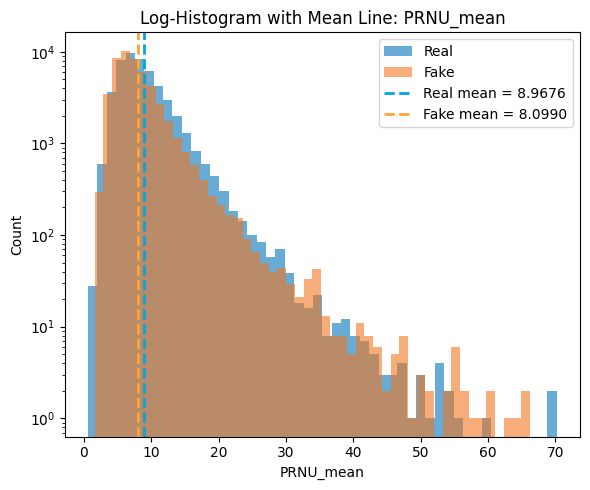

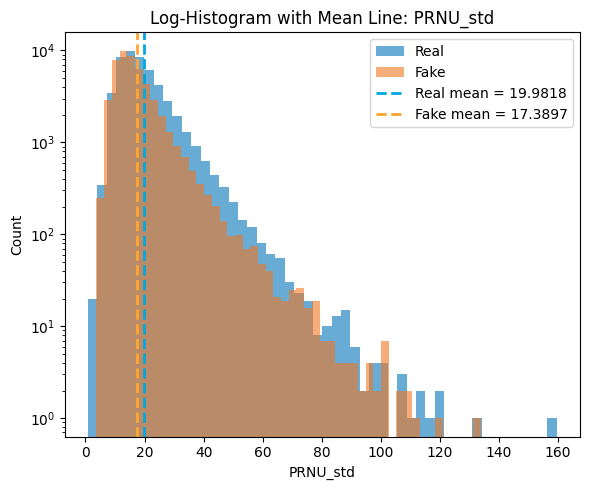

In [10]:
plot_log_histograms(df, "PRNU_mean")
plot_log_histograms(df, "PRNU_std")

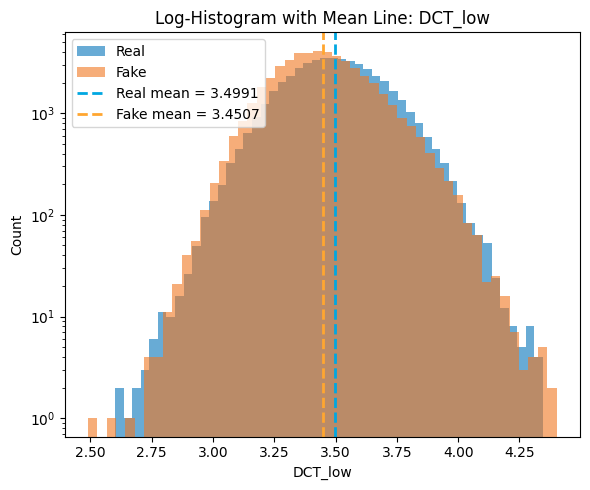

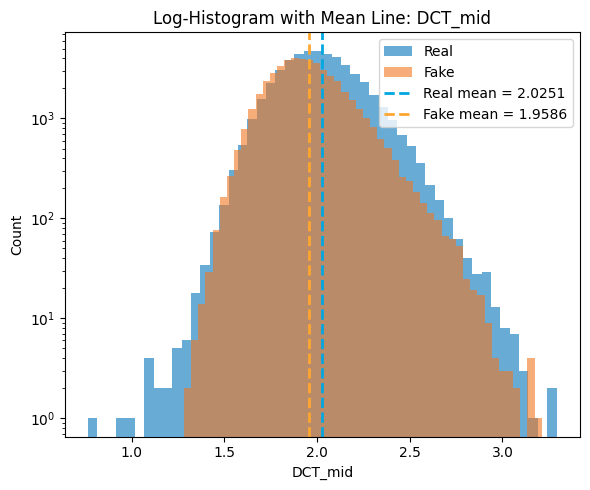

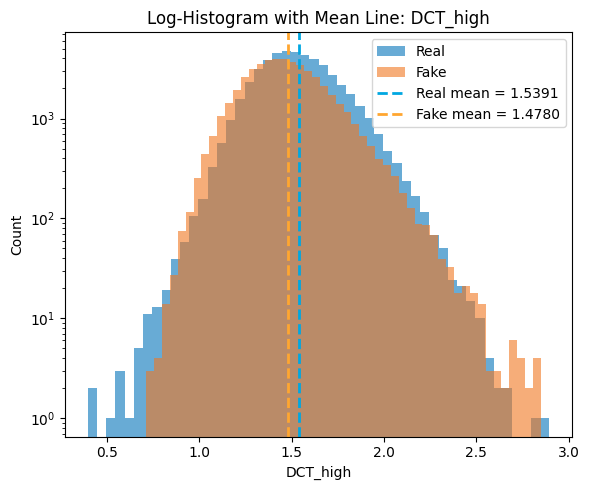

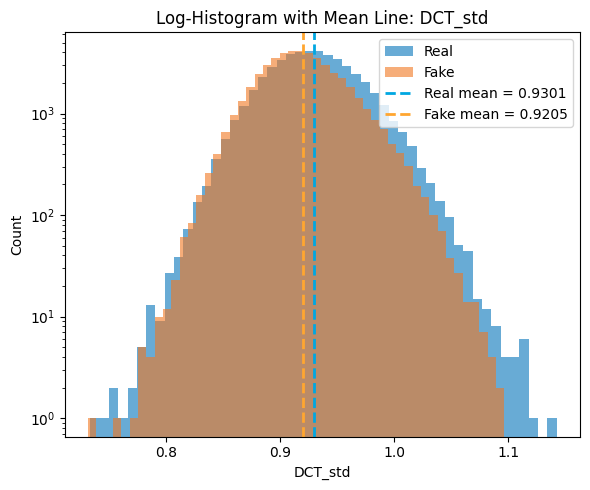

In [11]:
for col in ["DCT_low", "DCT_mid", "DCT_high", "DCT_std"]:
    plot_log_histograms(df, col)

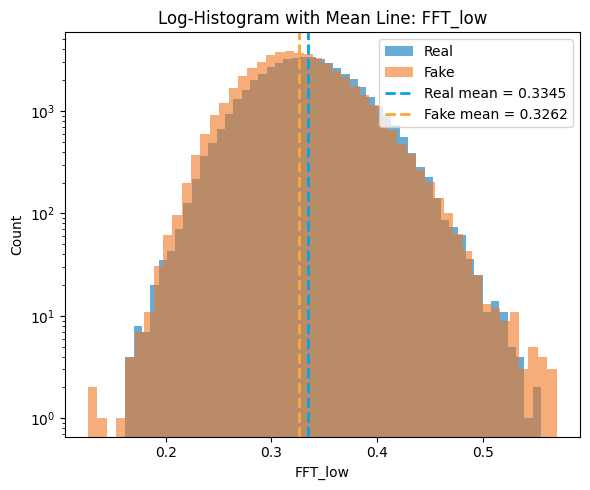

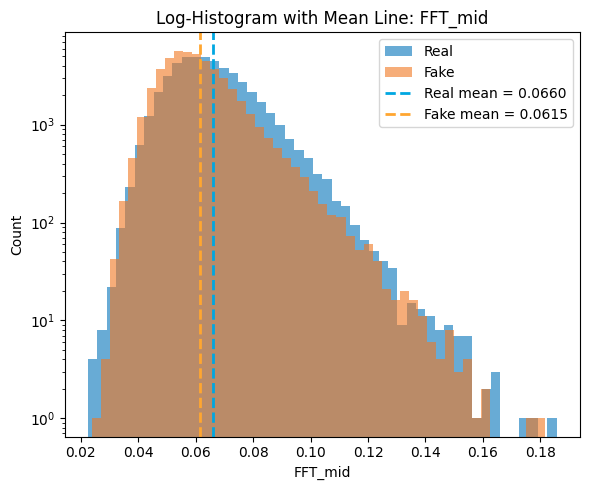

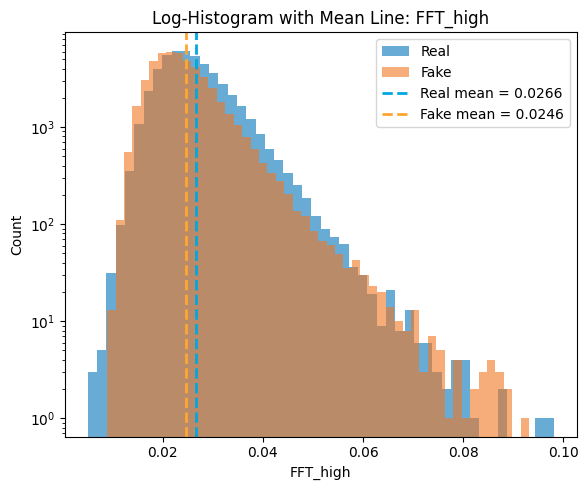

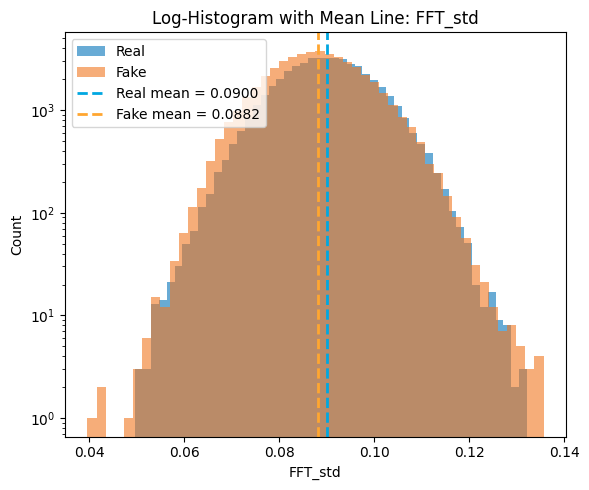

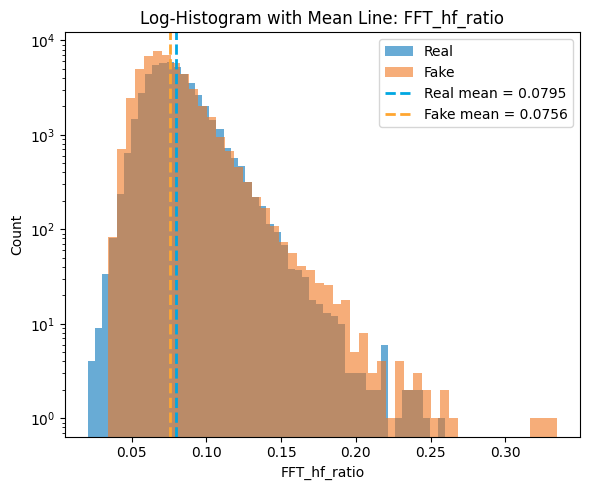

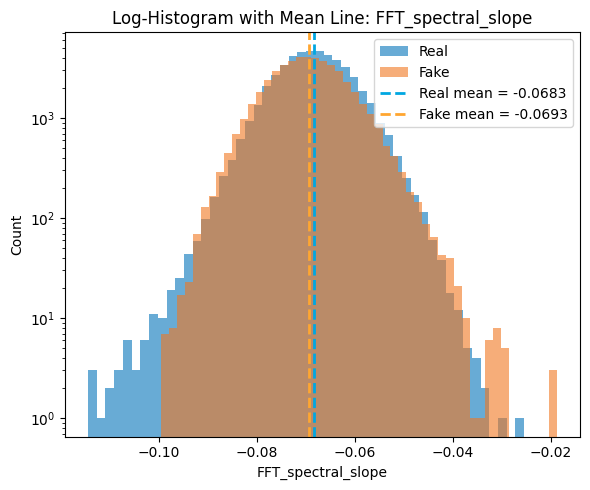

In [12]:
for col in ["FFT_low","FFT_mid","FFT_high","FFT_std","FFT_hf_ratio","FFT_spectral_slope"]:
    plot_log_histograms(df, col)

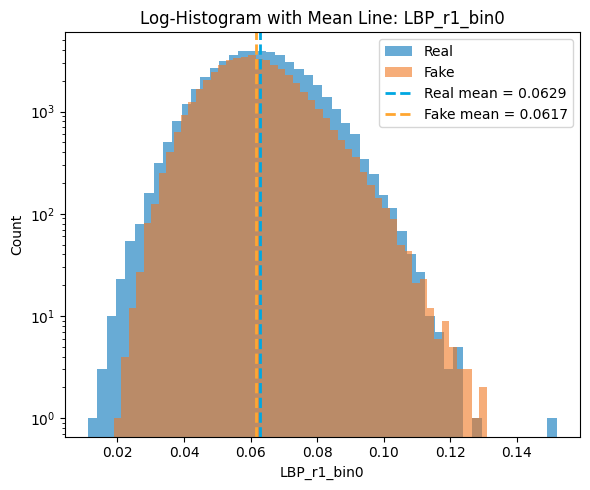

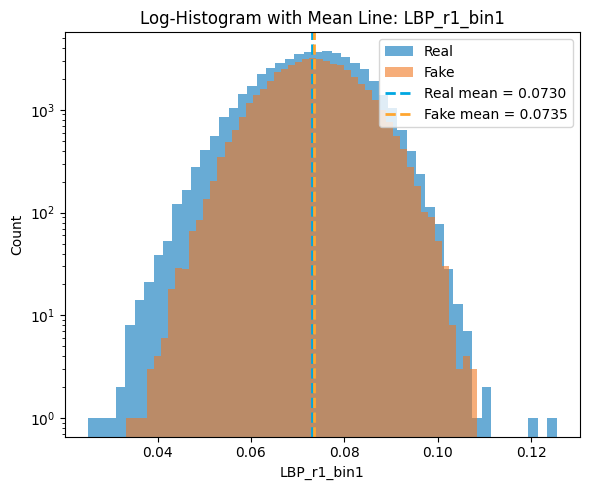

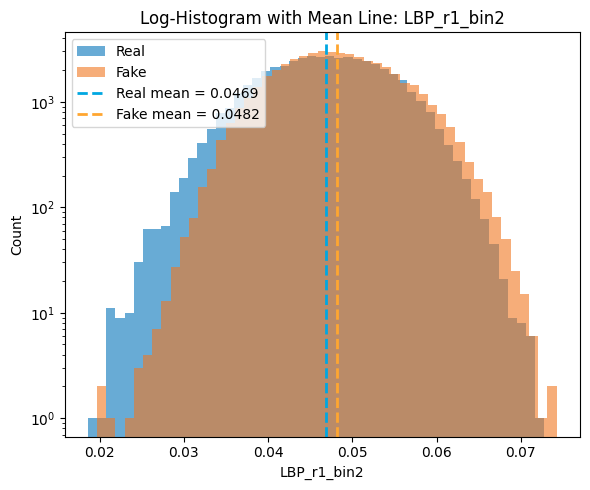

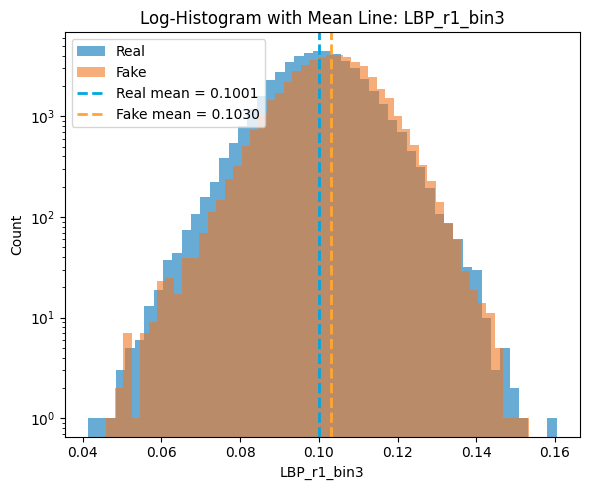

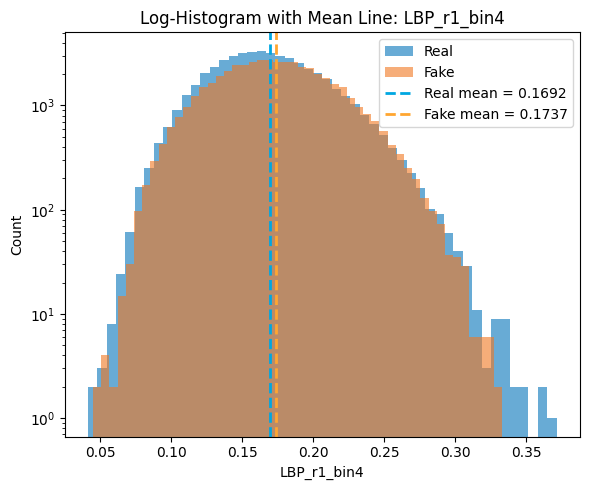

In [13]:
lbp_cols = [c for c in df.columns if "LBP" in c]
for col in lbp_cols[:5]:
    plot_log_histograms(df, col)

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=VAL_RATIO + TEST_RATIO, stratify=y, random_state=42
)
val_size = VAL_RATIO / (VAL_RATIO + TEST_RATIO)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=1 - val_size, stratify=y_temp, random_state=42
)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Features reduced from {X_train_scaled.shape[1]} → {X_train_pca.shape[1]}")

Features reduced from 186 → 31


In [16]:
# Save preprocessing
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")

['pca.pkl']

In [17]:
results = []
# Models and hyperparameter distributions 
models = {
    "BaggingClassifier": (
        BaggingClassifier(random_state=42, n_jobs=-1),
        {
            'n_estimators': [200, 300],
            'max_samples': [1.0, 0.8]
        }
    ),

    "ExtraTreesClassifier": (
        ExtraTreesClassifier(random_state=42, n_jobs=-1),
        {
            'n_estimators': [200, 300],
            'max_depth': [40, None]
        }
    ),

    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            'n_estimators': [200, 300],
            'max_depth': [20, 40]
        }
    ),

    "XGBoost": (
        XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        ),
        {
            'n_estimators': [200, 300],
            'max_depth': [7, 5],
            'learning_rate': [0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    ),

    "LightGBM": (
        LGBMClassifier(random_state=42, verbose=-1),
        {
            'n_estimators': [200, 300],
            'learning_rate': [0.1, 0.2],
            'num_leaves': [63, 31]
        }
    ),

    "CatBoost": (
        CatBoostClassifier(random_state=42, verbose=0),
        {
            'iterations': [200, 300],
            'depth': [8, 6],
            'learning_rate': [0.2, 0.1]
        }
    ),

    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            'n_estimators': [200, 300],
            'learning_rate': [0.5, 1.5]
        }
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [200, 300],
            'max_depth': [7, 5],
            'learning_rate': [0.1, 0.2]
        }
    )
}

In [18]:
# Feature configurations
feature_sets = {
    "no PCA": (X_train_scaled, X_test_scaled),
    "has PCA": (X_train_pca, X_test_pca)
}
for model_name, (base_model, params) in models.items():

    model_result = {"Model": model_name}

    for feature_key, (Xtr, Xte) in feature_sets.items():

        print(f"\n🔹 Training {model_name} with {feature_key}")

        start = time.time()
        clf = GridSearchCV(
            estimator=base_model,
            param_grid=params,
            cv=3,
            scoring='f1',
            n_jobs=-1
        )
        clf.fit(Xtr, y_train)
        train_time = time.time() - start

        acc = accuracy_score(y_test, clf.predict(Xte))

        print(f"Best {model_name} Params ({feature_key}): {clf.best_params_}")

        model_result[f"Accuracy-{feature_key}"] = acc
        model_result[f"TrainTime-{feature_key}"] = round(train_time, 2)

        model_save = f"{model_name.lower()}_{feature_key}.pkl"
        joblib.dump(clf.best_estimator_, model_save)

    results.append(model_result)


🔹 Training BaggingClassifier with no PCA
Best BaggingClassifier Params (no PCA): {'max_samples': 0.8, 'n_estimators': 300}

🔹 Training BaggingClassifier with has PCA
Best BaggingClassifier Params (has PCA): {'max_samples': 0.8, 'n_estimators': 300}

🔹 Training ExtraTreesClassifier with no PCA


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best ExtraTreesClassifier Params (no PCA): {'max_depth': 40, 'n_estimators': 300}

🔹 Training ExtraTreesClassifier with has PCA


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best ExtraTreesClassifier Params (has PCA): {'max_depth': None, 'n_estimators': 300}

🔹 Training RandomForest with no PCA


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RandomForest Params (no PCA): {'max_depth': 40, 'n_estimators': 300}

🔹 Training RandomForest with has PCA
Best RandomForest Params (has PCA): {'max_depth': 20, 'n_estimators': 300}

🔹 Training XGBoost with no PCA


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost Params (no PCA): {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

🔹 Training XGBoost with has PCA
Best XGBoost Params (has PCA): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

🔹 Training LightGBM with no PCA


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best LightGBM Params (no PCA): {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 63}

🔹 Training LightGBM with has PCA
Best LightGBM Params (has PCA): {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 63}

🔹 Training CatBoost with no PCA
Best CatBoost Params (no PCA): {'depth': 8, 'iterations': 300, 'learning_rate': 0.2}

🔹 Training CatBoost with has PCA
Best CatBoost Params (has PCA): {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}

🔹 Training AdaBoost with no PCA


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best AdaBoost Params (no PCA): {'learning_rate': 1.5, 'n_estimators': 300}

🔹 Training AdaBoost with has PCA


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best AdaBoost Params (has PCA): {'learning_rate': 0.5, 'n_estimators': 300}

🔹 Training GradientBoosting with no PCA
Best GradientBoosting Params (no PCA): {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}

🔹 Training GradientBoosting with has PCA
Best GradientBoosting Params (has PCA): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [19]:
df_results = pd.DataFrame(results, columns=[
    "Model", "Accuracy-no PCA", "TrainTime-no PCA",
    "Accuracy-has PCA", "TrainTime-has PCA"
])

display(df_results)

,Model,Accuracy-no PCA,TrainTime-no PCA,Accuracy-has PCA,TrainTime-has PCA
0,BaggingClassifier,0.76240,3534.96,0.76650,1940.10
1,ExtraTreesClassifier,0.76315,146.72,0.78005,90.43
2,RandomForest,0.76390,305.80,0.77380,368.21
3,XGBoost,0.81320,201.57,0.79575,87.43
4,LightGBM,0.80965,125.16,0.79285,74.58
5,CatBoost,0.80625,227.84,0.79600,126.19
6,AdaBoost,0.74515,545.49,0.73070,354.58
7,GradientBoosting,0.81165,4244.78,0.79040,3044.25


In [20]:
save_dir = "results_barplots"
os.makedirs(save_dir, exist_ok=True)

x = np.arange(len(df_results)) 
width = 0.35  

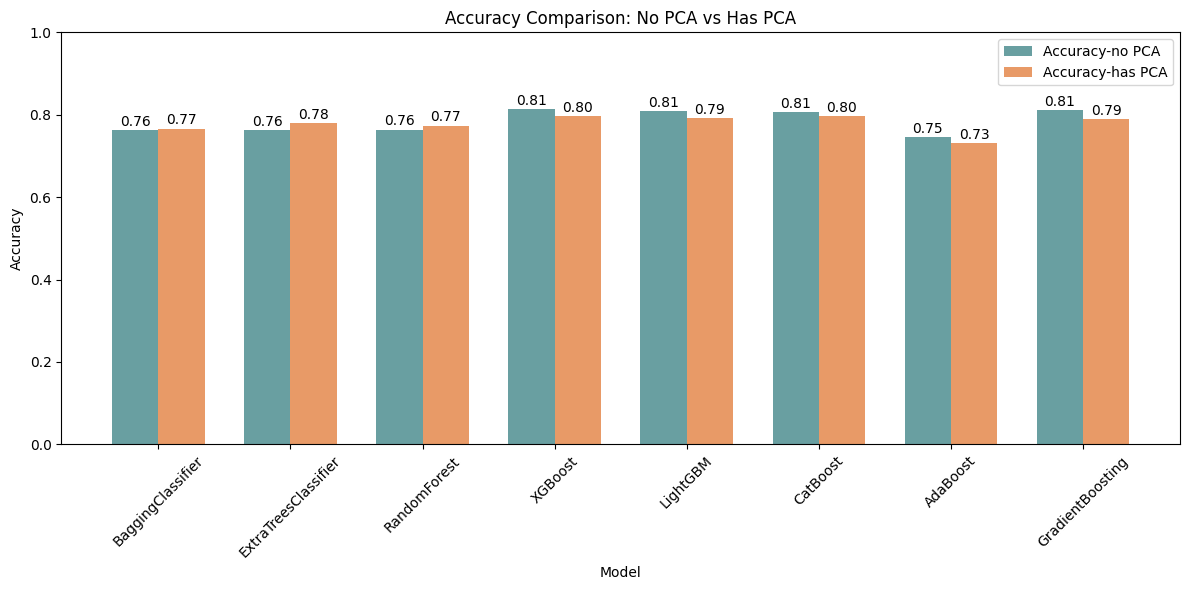

In [21]:
# Accuracy comparison
plt.figure(figsize=(12,6))

plt.bar(x - width/2, df_results['Accuracy-no PCA'], width, label='Accuracy-no PCA', color='#699FA1')
plt.bar(x + width/2, df_results['Accuracy-has PCA'], width, label='Accuracy-has PCA', color='#DF7027', alpha=0.7)

plt.title('Accuracy Comparison: No PCA vs Has PCA')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(x, df_results['Model'], rotation=45)
plt.ylim(0,1)

for i in range(len(df_results)):
    plt.text(x[i] - width/2, df_results['Accuracy-no PCA'][i]+0.01, f"{df_results['Accuracy-no PCA'][i]:.2f}", ha='center')
    plt.text(x[i] + width/2, df_results['Accuracy-has PCA'][i]+0.01, f"{df_results['Accuracy-has PCA'][i]:.2f}", ha='center')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Accuracy_comparison.png"))
plt.show()

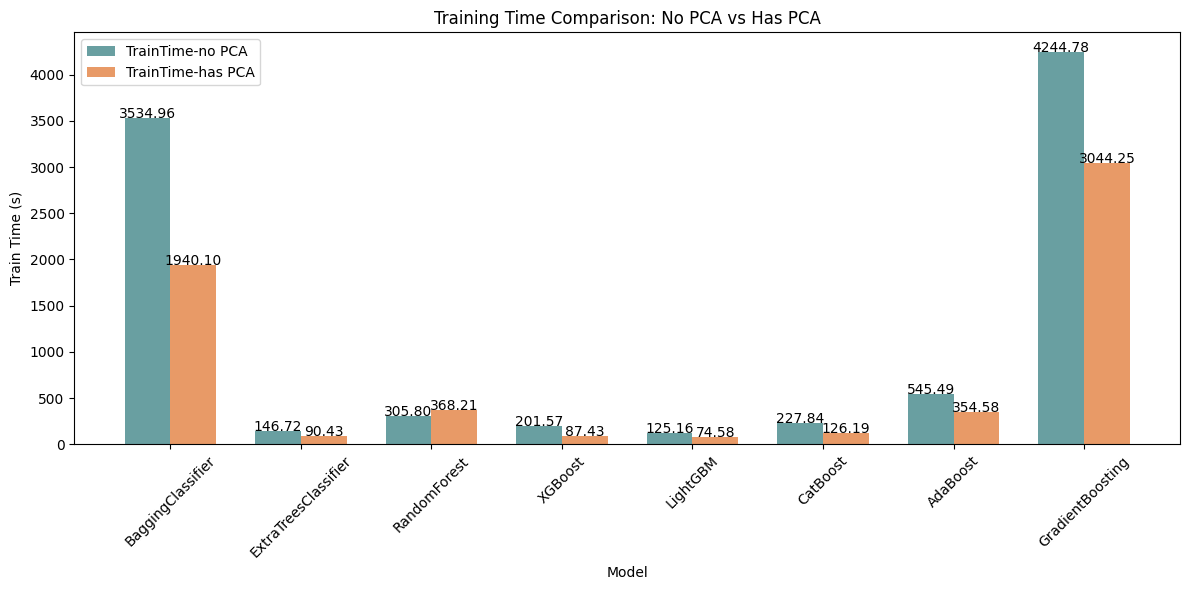

In [22]:
# Training Time comparison
plt.figure(figsize=(12,6))

plt.bar(x - width/2, df_results['TrainTime-no PCA'], width, label='TrainTime-no PCA', color='#699FA1')
plt.bar(x + width/2, df_results['TrainTime-has PCA'], width, label='TrainTime-has PCA', color='#DF7027', alpha=0.7)

plt.title('Training Time Comparison: No PCA vs Has PCA')
plt.ylabel('Train Time (s)')
plt.xlabel('Model')
plt.xticks(x, df_results['Model'], rotation=45)

for i in range(len(df_results)):
    plt.text(x[i] - width/2, df_results['TrainTime-no PCA'][i]+0.01, f"{df_results['TrainTime-no PCA'][i]:.2f}", ha='center')
    plt.text(x[i] + width/2, df_results['TrainTime-has PCA'][i]+0.01, f"{df_results['TrainTime-has PCA'][i]:.2f}", ha='center')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "TrainTime_comparison.png"))
plt.show()

In [23]:
save_dir = "metrics_plots"
os.makedirs(save_dir, exist_ok=True)
metrics_list = []

In [24]:
for model_info in results:
    model_name = model_info['Model']
    # load model đã train với PCA
    model_file = f"{model_name.lower()}_has PCA.pkl"
    clf = joblib.load(model_file)
    
    y_pred = clf.predict(X_test_pca)
    
    metrics_list.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted'),
        "TrainTime": model_info['TrainTime-has PCA']
    })

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index('Model')
display(metrics_df)

,Accuracy,Precision,Recall,F1-score,TrainTime
Model,,,,,
BaggingClassifier,0.76650,0.766910,0.76650,0.766410,1940.10
ExtraTreesClassifier,0.78005,0.781148,0.78005,0.779835,90.43
RandomForest,0.77380,0.774912,0.77380,0.773571,368.21
XGBoost,0.79575,0.796166,0.79575,0.795678,87.43
LightGBM,0.79285,0.793175,0.79285,0.792793,74.58
CatBoost,0.79600,0.796644,0.79600,0.795889,126.19
AdaBoost,0.73070,0.731160,0.73070,0.730566,354.58
GradientBoosting,0.79040,0.790933,0.79040,0.790304,3044.25


/tmp/ipykernel_19/2305795844.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values.index, y=values.values, palette=colors)


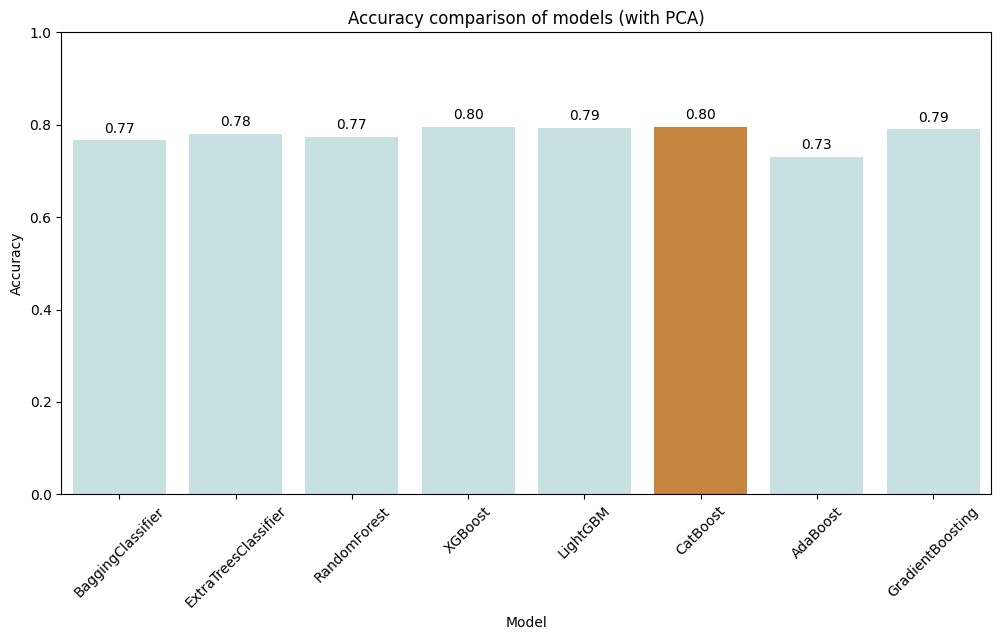

/tmp/ipykernel_19/2305795844.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values.index, y=values.values, palette=colors)


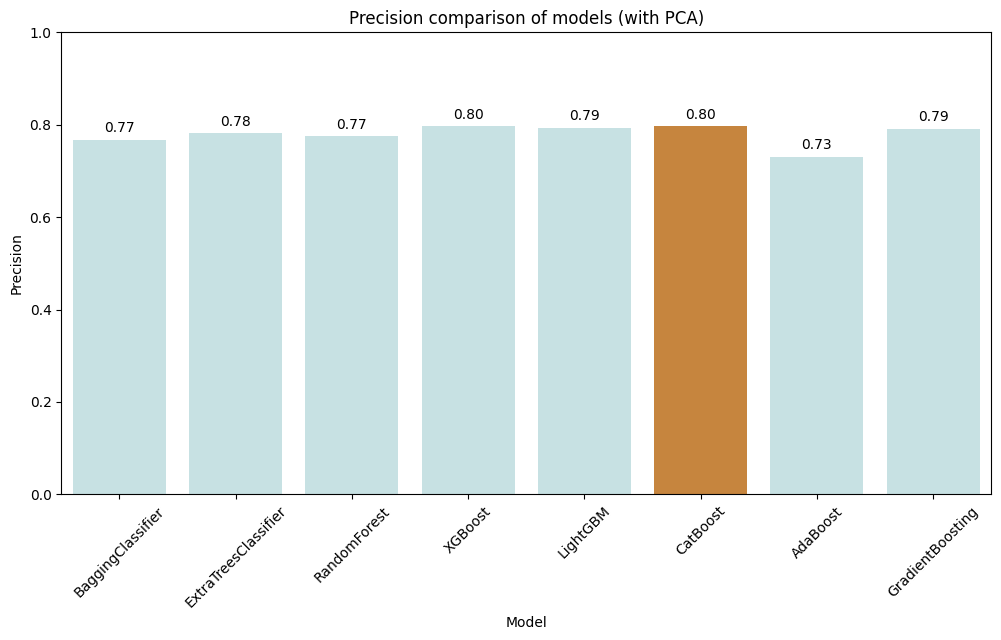

/tmp/ipykernel_19/2305795844.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values.index, y=values.values, palette=colors)


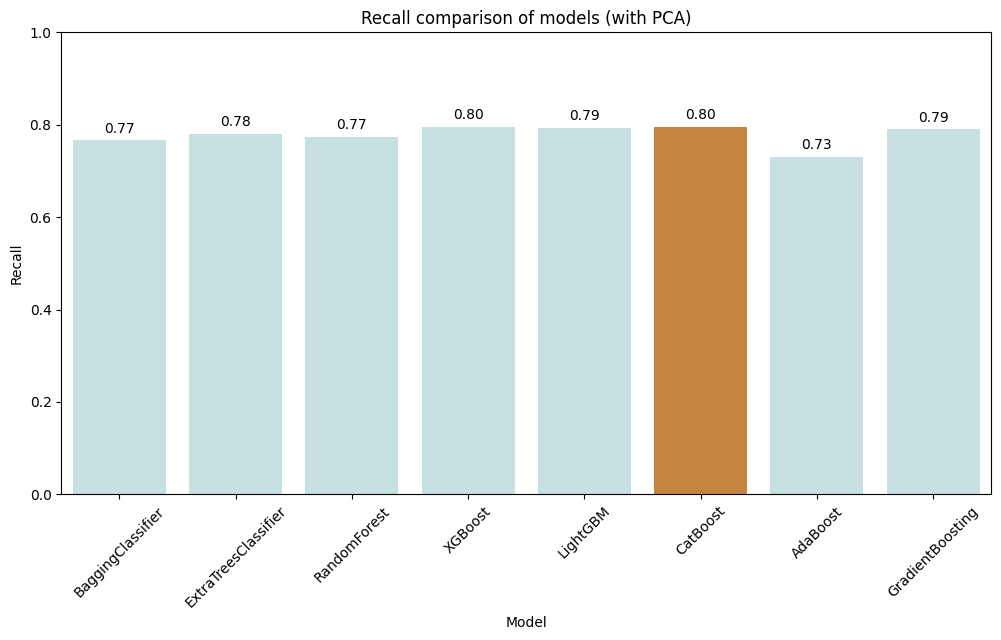

/tmp/ipykernel_19/2305795844.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values.index, y=values.values, palette=colors)


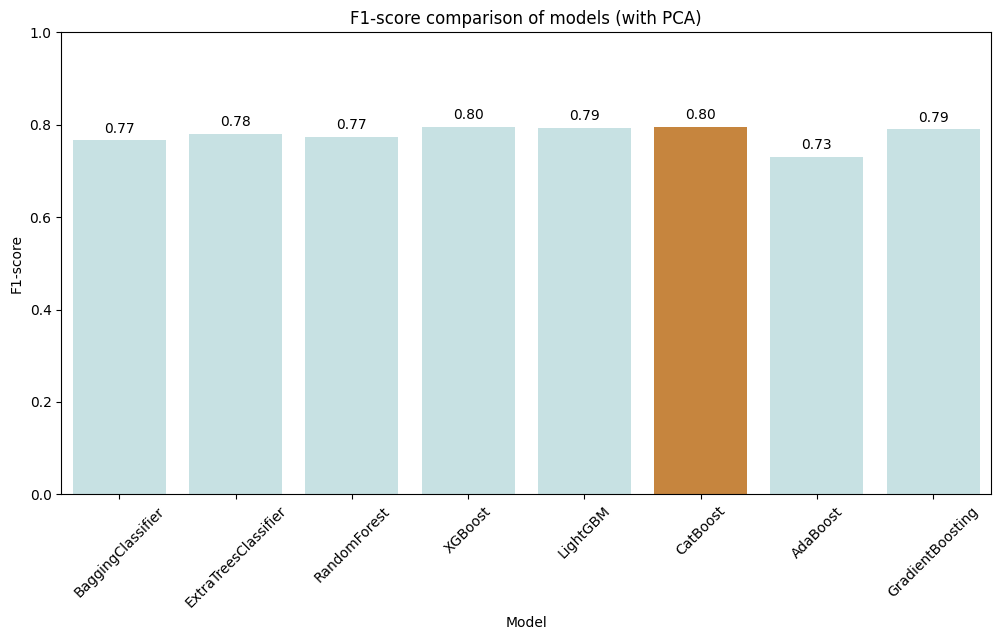

/tmp/ipykernel_19/2305795844.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=values.index, y=values.values, palette=colors)


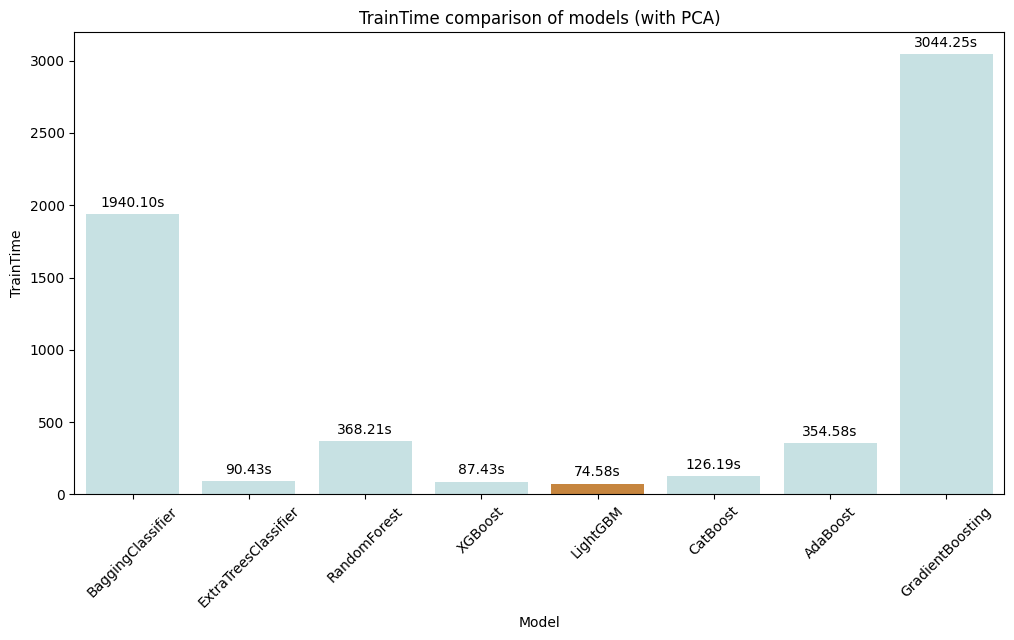

In [25]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'TrainTime']

for metric in metrics_to_plot:
    plt.figure(figsize=(12,6))
    values = metrics_df[metric]
    colors = ['#C3E5E7']*len(values)
    
    if metric == "TrainTime":
        idx = values.idxmin()
    else:
        idx = values.idxmax()
    colors[metrics_df.index.get_loc(idx)] = '#DD8627'
    
    ax = sns.barplot(x=values.index, y=values.values, palette=colors)
    plt.title(f'{metric} comparison of models (with PCA)')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)

    if metric != "TrainTime":
        plt.ylim(0, 1)
    
    for i, v in enumerate(values):
        if metric != "TrainTime":
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
        else:
            ax.text(i, v + 0.01*max(values), f"{v:.2f}s", ha='center', va='bottom')

    save_path = os.path.join(save_dir, f"{metric}_comparison.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [26]:
save_dir = "confusion_matrices"
os.makedirs(save_dir, exist_ok=True)


==================== BaggingClassifier ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     10000
           1       0.76      0.79      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
[[7469 2531]
 [2139 7861]]


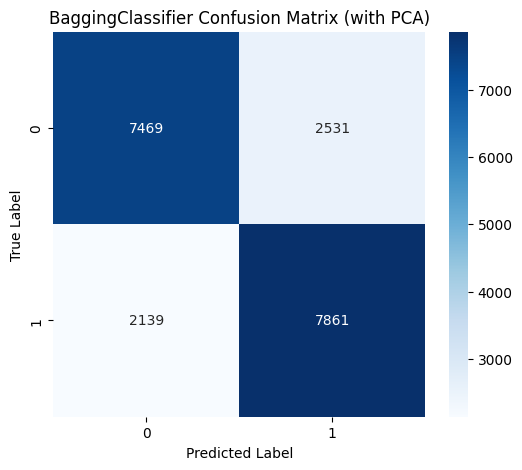


==================== ExtraTreesClassifier ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     10000
           1       0.76      0.81      0.79     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Confusion Matrix:
[[7488 2512]
 [1887 8113]]


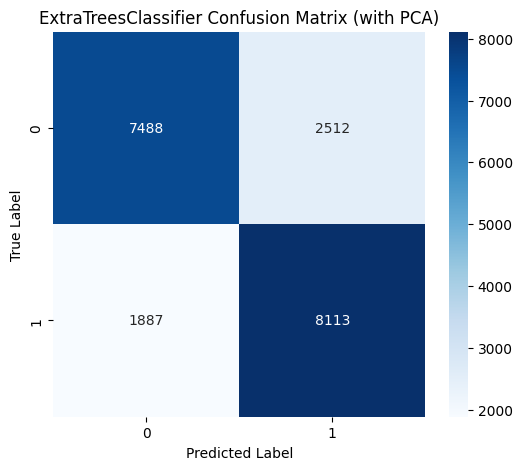


==================== RandomForest ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77     10000
           1       0.76      0.81      0.78     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
[[7420 2580]
 [1944 8056]]


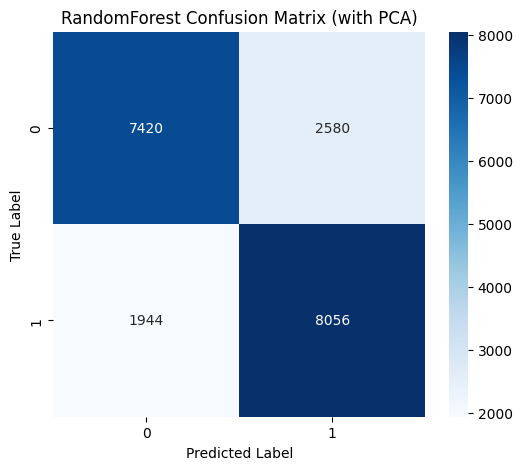


==================== XGBoost ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     10000
           1       0.79      0.81      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Confusion Matrix:
[[7770 2230]
 [1855 8145]]


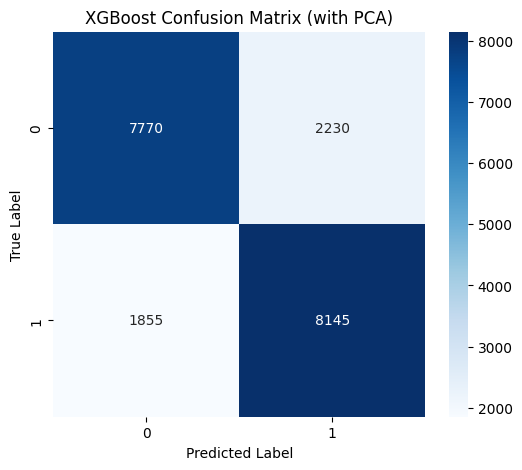


==================== LightGBM ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10000
           1       0.78      0.81      0.80     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
[[7762 2238]
 [1905 8095]]


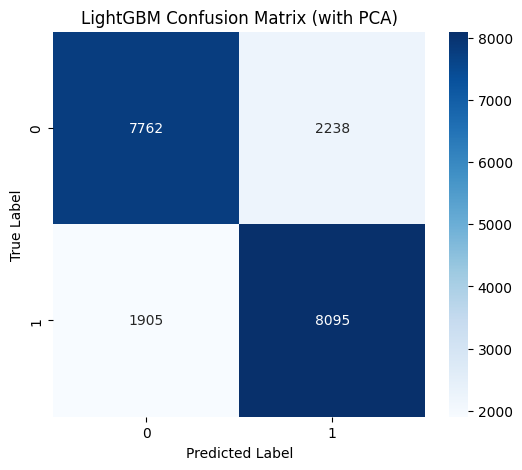


==================== CatBoost ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     10000
           1       0.78      0.82      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

Confusion Matrix:
[[7727 2273]
 [1807 8193]]


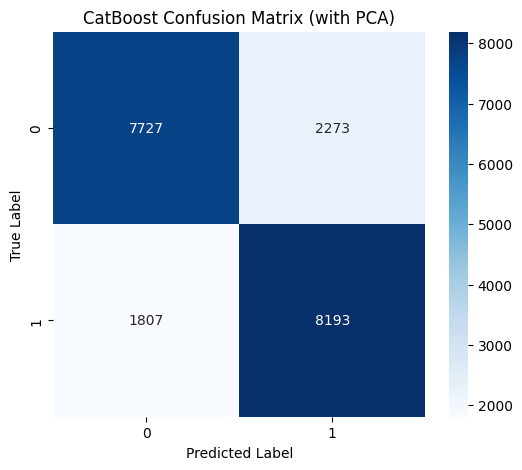


==================== AdaBoost ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72     10000
           1       0.72      0.75      0.74     10000

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000

Confusion Matrix:
[[7084 2916]
 [2470 7530]]


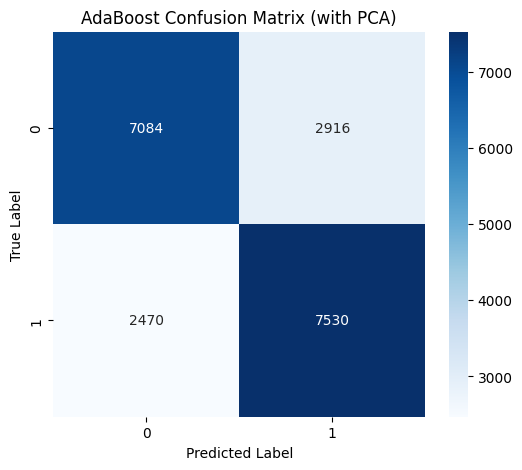


==================== GradientBoosting ====================
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     10000
           1       0.78      0.81      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000

Confusion Matrix:
[[7690 2310]
 [1882 8118]]


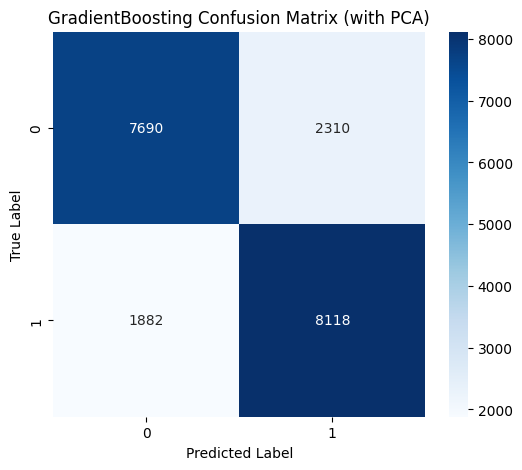

In [27]:
for model_info in results:
    model_name = model_info['Model']
    model_file = f"{model_name.lower()}_has PCA.pkl"

    clf = joblib.load(model_file)
    
    y_pred = clf.predict(X_test_pca)
    
    print(f"\n==================== {model_name} ====================")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix (with PCA)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    save_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

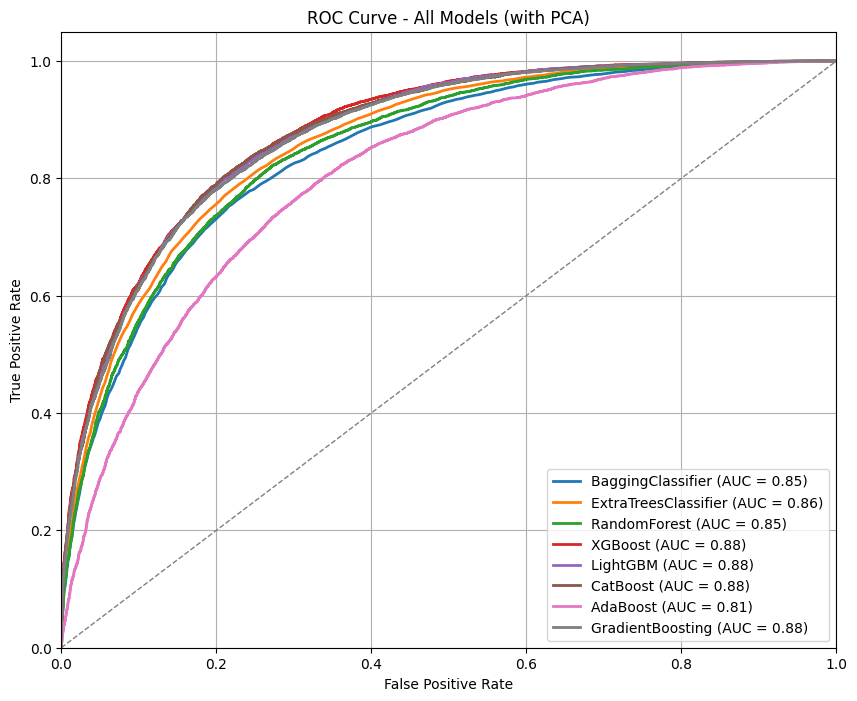

In [28]:
save_dir = "metrics_plots"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(10,8))

for model_info in results:
    model_name = model_info['Model']
    model_file = f"{model_name.lower()}_has PCA.pkl"
    
    # Load model
    clf = joblib.load(model_file)
    
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test_pca)[:,1]
    else:  # với SVM sử dụng decision_function
        y_score = clf.decision_function(X_test_pca)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models (with PCA)')
plt.legend(loc="lower right")
plt.grid(True)

save_path = os.path.join(save_dir, "ROC_Curve_All_Models.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()